# Explore feature space

## Setup

In [1]:
# import libraries
import os
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pqdm.processes import pqdm
from tqdm.notebook import tqdm

import utils

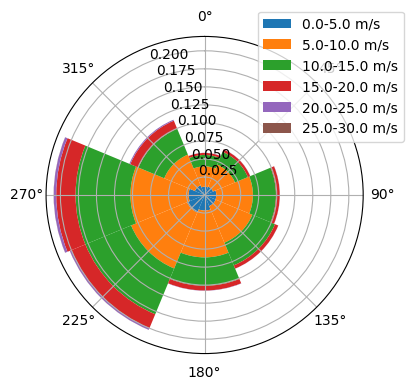

In [2]:
# visualise wind distribution
fig, ax = plt.subplots(figsize=(6, 4))
_ = utils.wfm_low.site.plot_wd_distribution(
    n_wd=8, ws_bins=[0, 5, 10, 15, 20, 25, 30], ax=ax
)
fig.tight_layout()

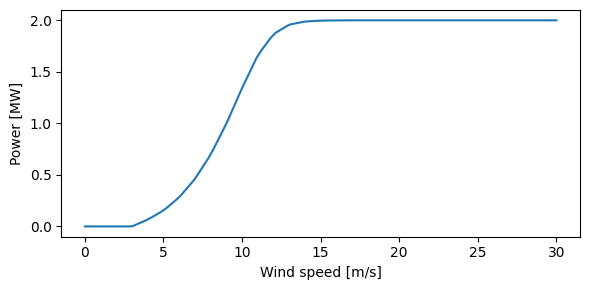

In [3]:
# visualise turbine power curve
fig, ax = plt.subplots(figsize=(6, 3))
ws = np.linspace(0, 30, 100)
ax.plot(ws, utils.wfm_low.windTurbines.power(ws) / 1e6)
ax.set_xlabel("Wind speed [m/s]")
ax.set_ylabel("Power [MW]")
fig.tight_layout()

## Baseline value

In [4]:
# run simulation
sim_res_base = utils.run_sim()
_ = utils.calc_metrics(sim_res=sim_res_base, sim_res_base=sim_res_base, show=True)

LCoE [USD/MWh]: 24.456
Capacity factor [%]: 91.254


## Assess across coarse range of yaw combinations for all turbines

In [5]:
coarse_dir = os.path.join("data", "coarse_sweep.h5")
yaw_ind_coarse = {f"yaw_{i}": [-5, 0, 5] for i in sim_res_base.wt.values}
if os.path.isfile(coarse_dir):
    ds_coarse = xr.open_dataset(coarse_dir)
else:
    # initialise dataset
    nt = len(sim_res_base.wt)
    power_installed = (
        sim_res_base.windFarmModel.windTurbines.powerCtFunction.power_ct_tab[0].max()
        / 1e9
        * nt
    )
    ds_coarse = xr.Dataset(
        data_vars={
            "lcoe": (
                yaw_ind_coarse.keys(),
                np.zeros(tuple(len(x) for x in yaw_ind_coarse.values())),
            ),
            "cap_fac": (
                yaw_ind_coarse.keys(),
                np.zeros(tuple(len(x) for x in yaw_ind_coarse.values())),
            ),
            "aep": (
                ["wt"] + list(yaw_ind_coarse.keys()),
                np.zeros((nt,) + tuple(len(x) for x in yaw_ind_coarse.values())),
            ),
        },
        coords={"wt": list(sim_res_base.wt.values)} | yaw_ind_coarse,
    )
    # calculate across full range of options
    yaw_options_coarse = list(product(*yaw_ind_coarse.values()))
    simulations = {
        k: v
        for k, v in zip(
            yaw_options_coarse,
            pqdm(
                [{"yaw": x} for x in yaw_options_coarse],
                utils.run_sim,
                n_jobs=int(0.75 * os.cpu_count()),
                argument_type="kwargs",
            ),
        )
    }
    for yaw_option, sim_res in simulations.items():
        lcoe, cap_fac = utils.calc_metrics(sim_res=sim_res, sim_res_base=sim_res_base)
        ds_coarse["lcoe"].loc[*yaw_option] = lcoe
        ds_coarse["cap_fac"].loc[*yaw_option] = cap_fac
        ds_coarse["aep"].loc[:, *yaw_option] = sim_res.aep().sum(["wt", "ws"]).values
    # save file
    ds_coarse.to_netcdf(coarse_dir)

In [6]:
# flatten and sort values
flat_lcoe_coarse = ds_coarse.lcoe.stack(all_dims=yaw_ind_coarse.keys())
flat_lcoe_coarse = flat_lcoe_coarse.sortby(flat_lcoe_coarse)
display(flat_lcoe_coarse)
yaw_opt_coarse = flat_lcoe_coarse["all_dims"][0].values.tolist()

<xarray.DataArray 'lcoe' (all_dims: 19683)>
array([24.41877664, 24.41877664, 24.41877664, ..., 24.4991631 ,
       24.4991631 , 24.4991631 ])
Coordinates:
  * all_dims  (all_dims) object MultiIndex
  * yaw_0     (all_dims) int64 -5 -5 -5 -5 5 5 5 5 -5 -5 ... 0 0 0 0 0 0 0 0 0 0
  * yaw_1     (all_dims) int64 -5 -5 5 5 -5 -5 5 5 -5 -5 ... 0 0 0 0 0 0 0 0 0 0
  * yaw_2     (all_dims) int64 -5 5 -5 5 -5 5 -5 5 -5 -5 ... 0 0 0 0 0 0 0 0 0 0
  * yaw_3     (all_dims) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 5 5 5 5 5 5 5 5 5 5 5
  * yaw_4     (all_dims) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 5 5 5 5 5 5 5 5 5 5 5
  * yaw_5     (all_dims) int64 0 0 0 0 0 0 0 0 -5 5 -5 ... -5 -5 5 5 5 5 5 5 5 5
  * yaw_6     (all_dims) int64 0 0 0 0 0 0 0 0 0 0 0 ... 5 5 -5 -5 -5 -5 5 5 5 5
  * yaw_7     (all_dims) int64 0 0 0 0 0 0 0 0 0 0 0 ... 5 5 -5 -5 5 5 -5 -5 5 5
  * yaw_8     (all_dims) int64 0 0 0 0 0 0 0 0 0 0 ... -5 5 -5 5 -5 5 -5 5 -5 5

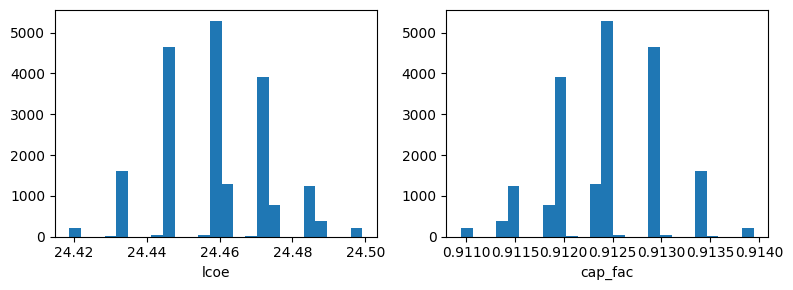

In [7]:
# plot distribution of values
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))
_ = ds_coarse.lcoe.plot.hist(bins=25, ax=ax[0])
_ = ds_coarse.cap_fac.plot.hist(bins=25, ax=ax[1])
fig.tight_layout()

In [8]:
# run simulation using optimum yaw
sim_res_opt_coarse = utils.run_sim(yaw=yaw_opt_coarse)
print("--- Base ---")
_ = utils.calc_metrics(sim_res=sim_res_base, sim_res_base=sim_res_base, show=True)
print("\n--- Optimum ---")
_ = utils.calc_metrics(sim_res=sim_res_opt_coarse, sim_res_base=sim_res_base, show=True)

--- Base ---
LCoE [USD/MWh]: 24.456
Capacity factor [%]: 91.254

--- Optimum ---
LCoE [USD/MWh]: 24.419
Capacity factor [%]: 91.394


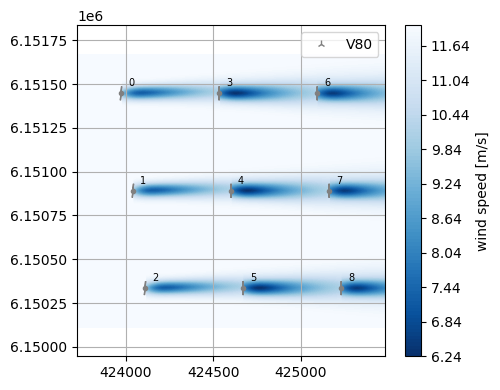

In [9]:
# plot flow map
fig, ax = plt.subplots(figsize=(5, 4))
fm = utils.run_sim(yaw=yaw_opt_coarse, ws=12).flow_map()
fm.plot_wake_map(ax=ax)
ax.grid()
fig.tight_layout()

Observations
- Small but noticeable improvement in capacity factor and LCoE
- Movement of only front row is all that is needed
- Direction of movement in turbines appears independent across rows

## Assess across fine range of yaw combinations for two turbines

In [10]:
fine_dir = os.path.join("data", "fine_sweep.h5")
yaw_ind_fine = {
    f"yaw_{i}": np.arange(-30, 30.5, 0.5) for i in sim_res_base.wt.values[[1, 4]]
}
if os.path.isfile(fine_dir):
    ds_fine = xr.open_dataset(fine_dir)
else:
    # initialise dataset
    nt = len(sim_res_base.wt)
    power_installed = (
        sim_res_base.windFarmModel.windTurbines.powerCtFunction.power_ct_tab[0].max()
        / 1e9
        * nt
    )
    ds_fine = xr.Dataset(
        data_vars={
            "lcoe": (
                yaw_ind_fine.keys(),
                np.zeros(tuple(len(x) for x in yaw_ind_fine.values())),
            ),
            "cap_fac": (
                yaw_ind_fine.keys(),
                np.zeros(tuple(len(x) for x in yaw_ind_fine.values())),
            ),
            "aep": (
                ["wt"] + list(yaw_ind_fine.keys()),
                np.zeros((nt,) + tuple(len(x) for x in yaw_ind_fine.values())),
            ),
        },
        coords={"wt": list(sim_res_base.wt.values)} | yaw_ind_fine,
    )
    # calculate across full range of options
    yaw_options_fine = list(
        product(*[yaw_ind_fine.get(f"yaw_{x}", [0]) for x in sim_res_base.wt.values])
    )
    simulations = {
        k: v
        for k, v in zip(
            yaw_options_fine,
            pqdm(
                [{"yaw": x} for x in yaw_options_fine],
                utils.run_sim,
                n_jobs=int(0.75 * os.cpu_count()),
                argument_type="kwargs",
            ),
        )
    }
    for yaw_option, sim_res in simulations.items():
        lcoe, cap_fac = utils.calc_metrics(sim_res=sim_res, sim_res_base=sim_res_base)
        ds_fine["lcoe"].loc[yaw_option[1], yaw_option[4]] = lcoe
        ds_fine["cap_fac"].loc[yaw_option[1], yaw_option[4]] = cap_fac
        ds_fine["aep"].loc[:, yaw_option[1], yaw_option[4]] = (
            sim_res.aep().sum(["wt", "ws"]).values
        )
    # save file
    ds_fine.to_netcdf(fine_dir)

In [11]:
# flatten and sort values
flat_lcoe_fine = ds_fine.lcoe.stack(all_dims=yaw_ind_fine.keys())
flat_lcoe_fine = flat_lcoe_fine.sortby(flat_lcoe_fine)
display(flat_lcoe_fine)
yaw_opt_fine = list((0,) * len(ds_fine.wt))
yaw_opt_fine[1], yaw_opt_fine[4] = flat_lcoe_fine["all_dims"][0].values.tolist()
yaw_opt_fine = tuple(yaw_opt_fine)

<xarray.DataArray 'lcoe' (all_dims: 14641)>
array([24.4114558 , 24.4114558 , 24.4114558 , ..., 25.03379074,
       25.03379074, 25.03379074])
Coordinates:
  * all_dims  (all_dims) object MultiIndex
  * yaw_1     (all_dims) float64 -14.0 -14.0 14.0 14.0 ... -30.0 -30.0 30.0 30.0
  * yaw_4     (all_dims) float64 -2.5 2.5 -2.5 2.5 ... -30.0 30.0 -30.0 30.0

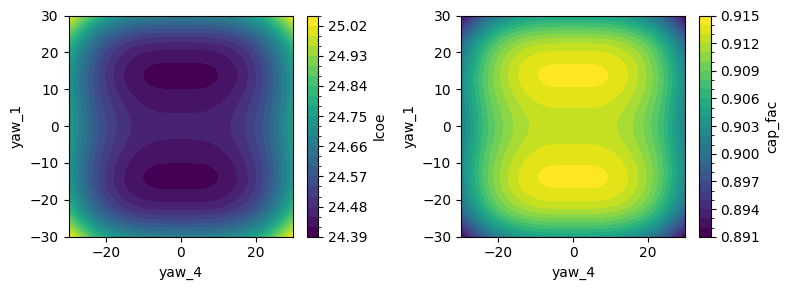

In [12]:
# plot distribution of values
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))
_ = ds_fine.lcoe.plot.contourf(levels=25, ax=ax[0])
_ = ds_fine.cap_fac.plot.contourf(levels=25, ax=ax[1])
fig.tight_layout()

In [13]:
# run simulation using optimum yaw
sim_res_opt_fine = utils.run_sim(yaw=yaw_opt_fine)
print("--- Base ---")
_ = utils.calc_metrics(sim_res=sim_res_base, sim_res_base=sim_res_base, show=True)
print("\n--- Optimum ---")
_ = utils.calc_metrics(sim_res=sim_res_opt_fine, sim_res_base=sim_res_base, show=True)

--- Base ---
LCoE [USD/MWh]: 24.456
Capacity factor [%]: 91.254

--- Optimum ---
LCoE [USD/MWh]: 24.411
Capacity factor [%]: 91.422


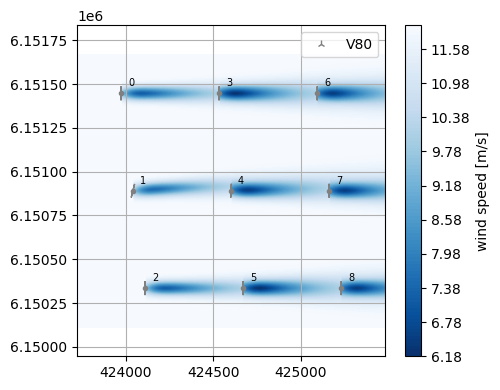

In [14]:
# plot flow map
fig, ax = plt.subplots(figsize=(5, 4))
fm = utils.run_sim(yaw=yaw_opt_fine, ws=12).flow_map()
fm.plot_wake_map(ax=ax)
ax.grid()
fig.tight_layout()

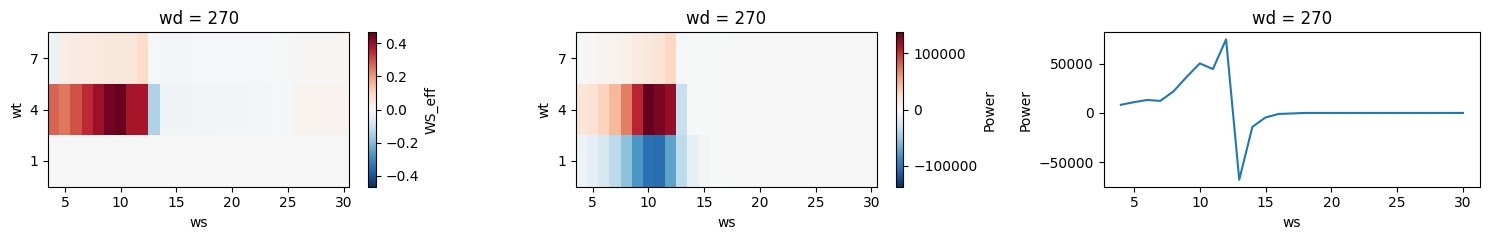

In [15]:
# plot distribution of values
fig, ax = plt.subplots(ncols=3, figsize=(15, 2.5))
WS_eff_ratio = (sim_res_opt_fine.WS_eff - sim_res_base.WS_eff).loc[[1, 4, 7], :, 4:]
Power_ratio = (sim_res_opt_fine.Power - sim_res_base.Power).loc[[1, 4, 7], :, 4:]
WS_eff_ratio.plot(ax=ax[0])
Power_ratio.plot(ax=ax[1])
Power_ratio.sum("wt").plot(ax=ax[2])
ax[0].set_yticks(WS_eff_ratio.wt)
ax[1].set_yticks(Power_ratio.wt)
fig.tight_layout()

Observations
- Larger improvement in performance due to larger yaw angles, despite only altering one of three rows of turbines
- Movement of only front row still yields best results
- Direction of movement remains irrelevant
- Off design performance is good - not too sensitive near optimum
- Improvements increase with wind speed until maximal power output
    - Near maximal power output speed the increase of the second turbine is minimal as the power curve flattens so a net loss is observed
- Optimal yaw likely a function of wind speed